In [4]:
import json
import math
import clingo
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import batched

DATA_FILE = '../Data/daily_01_2024-07-05.json'
SCHEDULER_SOURCE = '../Source/schedule_discrete.lp'

# This context class allows defining utility methods in Python to be called in the ASP code
class Context:
    def clamp(self, x, lower, upper):
        return min(max(x, lower), upper)
    
    def max(self, a, b):
        return max(a, b)
    
    def min(self, a, b):
        return min(a, b)

# Read model inputs from data file
with open(DATA_FILE) as f:
    data = json.load(f)

# Read base model source
with open(SCHEDULER_SOURCE) as f:
    scheduler_program = f.read()


# Function that prints model output
def print_model(model):
    atoms = model.symbols(shown=True)
    grouped = {}

    # group atoms by predicate name
    for atom in atoms:
        grouped.setdefault(atom.name, []).append(atom)

    # print neatly grouped
    for pred in grouped.keys():
        print(f"% {pred} facts:")
        for fact in sorted(grouped[pred]):
            print(f"  {fact}")
        print()

# Function that prints model summary to track optimization process
def summarize_model(model):
    print(f'[{datetime.now().strftime("%H:%M:%S")}] Found model #{model.number} with cost {model.cost}; Optimal: {model.optimality_proven}')

# Add in facts from data file
#
# Note that we just generate ASP code to pass to Clingo. It should be possible to pass symbolic constructs
# instead to prevent the string format/parse pass, but the API for that is a bit finicky. So this works as well.
#
# Also note that we are enumerating two slots in a batch. This is to convert from 30 minute slots to 1 hour slots.
# This is to reduce computational complexity.
program_input = ''
batch_count = 4
for (hour, slots) in enumerate(batched(data['schedule_input'], n=batch_count)):
    slot_count = len(slots)

    # Average price between slots, in tenth of cents
    price = sum((slot['price_buying'] * 1000 for slot in slots)) / slot_count

    # Production and consumption are in Wh, not in W. So we use the sum
    production_ac = 0#sum((slot['production_forecast_ac'] for slot in slots))
    production_dc = 0#sum((slot['production_forecast_dc'] for slot in slots))
    consumption = 0#sum((slot['consumption_forecast'] for slot in slots))

    # Output all the atoms as string values in the ASP language
    program_input += f'price({hour + 1}, {round(price)}).\n'
    program_input += f'production({hour + 1}, {round(production_ac + production_dc)}).\n'
    program_input += f'consumption({hour + 1}, {round(consumption)}).\n'

hours = math.ceil(len(data['schedule_input']) / batch_count)

# Put all the constants we want to input in a dict for easy mapping to strings
site = data['site_info']
constants = \
{
    'hours': hours,
    'max_charge_rate': site['max_charge_amount'] * batch_count * 100 / site['battery_capacity'],
    'max_discharge_rate': site['max_discharge_amount'] * batch_count * 100 / site['battery_capacity'],
    'charge_efficiency': site['charge_efficiency_from_ac'] * 100,
    'discharge_efficiency': site['discharge_efficiency_to_ac'] * 100,
}

# Construct command-line parameters as a list of strings
parameters = \
[ 
    # Extra parameters for Clingo
    '--stats', 
    '--parallel-mode', '4',

    # Create -c flag and key=value format for each constant
    *[ s for (key, value) in constants.items() for s in [ '-c', f'{key}={round(value)}' ] ],
]

ctl = clingo.Control(parameters)

print(f'Composite input:')
print(program_input)
print()

# Construct the model from base program + input
print(f'Constructing model...')
ctl.add("input", [], program_input)
ctl.add("base", [], scheduler_program)

# Ground the model
print(f'Grounding model...')
ctl.ground([("input", []), ("base", [ ])], context=Context())

# And solve it
print(f'Starting solve...')
result = ctl.solve(on_model=summarize_model, on_last=print_model)

print(f'Solving result: {result}')
print('Stats:')
print(f'Atoms: {ctl.statistics["problem"]["lp"]["atoms"]}')
print(f'Rules: {ctl.statistics["problem"]["lp"]["rules"]}')
print(f'Choices: {ctl.statistics["solving"]["solvers"]["choices"]}')
print(f'Total time: {ctl.statistics["summary"]["times"]["total"]:.2f}s')

# Containers for results
results = {
    "schedule": {},
    "soc": {},
    "inverter_power": {},
    "price": {},
    "cost": {}
}

def collect_model(model):
    atoms = model.symbols(shown=True)
    for atom in atoms:
        name = atom.name
        args = atom.arguments

        # Unpack "holds" (fluents) and "occurs" (actions)
        if name == 'holds' or name == 'occurs':
            name = args[0].name
            args = args[1:] + args[0].arguments

        if name in results and len(args) == 2:
            h = int(str(args[0]))
            v = str(args[1])
            if v.lstrip('-').isdigit():
                v = int(v)
            results[name][h] = v

# Run solver with this callback
ctl.solve(on_last=collect_model)


Composite input:
price(1, 92).
production(1, 0).
consumption(1, 0).
price(2, 62).
production(2, 0).
consumption(2, 0).
price(3, 31).
production(3, 0).
consumption(3, 0).
price(4, 7).
production(4, 0).
consumption(4, 0).
price(5, 2).
production(5, 0).
consumption(5, 0).
price(6, -24).
production(6, 0).
consumption(6, 0).
price(7, -53).
production(7, 0).
consumption(7, 0).
price(8, -113).
production(8, 0).
consumption(8, 0).
price(9, -86).
production(9, 0).
consumption(9, 0).
price(10, -8).
production(10, 0).
consumption(10, 0).
price(11, 10).
production(11, 0).
consumption(11, 0).
price(12, 20).
production(12, 0).
consumption(12, 0).


Constructing model...
Grounding model...
Starting solve...
[11:27:32] Found model #1 with cost [4480]; Optimal: False
[11:27:32] Found model #2 with cost [4340]; Optimal: False
[11:27:32] Found model #3 with cost [2660]; Optimal: False
[11:27:32] Found model #4 with cost [-1540]; Optimal: False
[11:27:32] Found model #5 with cost [-7665]; Optimal: False
[

SolveResult(5)

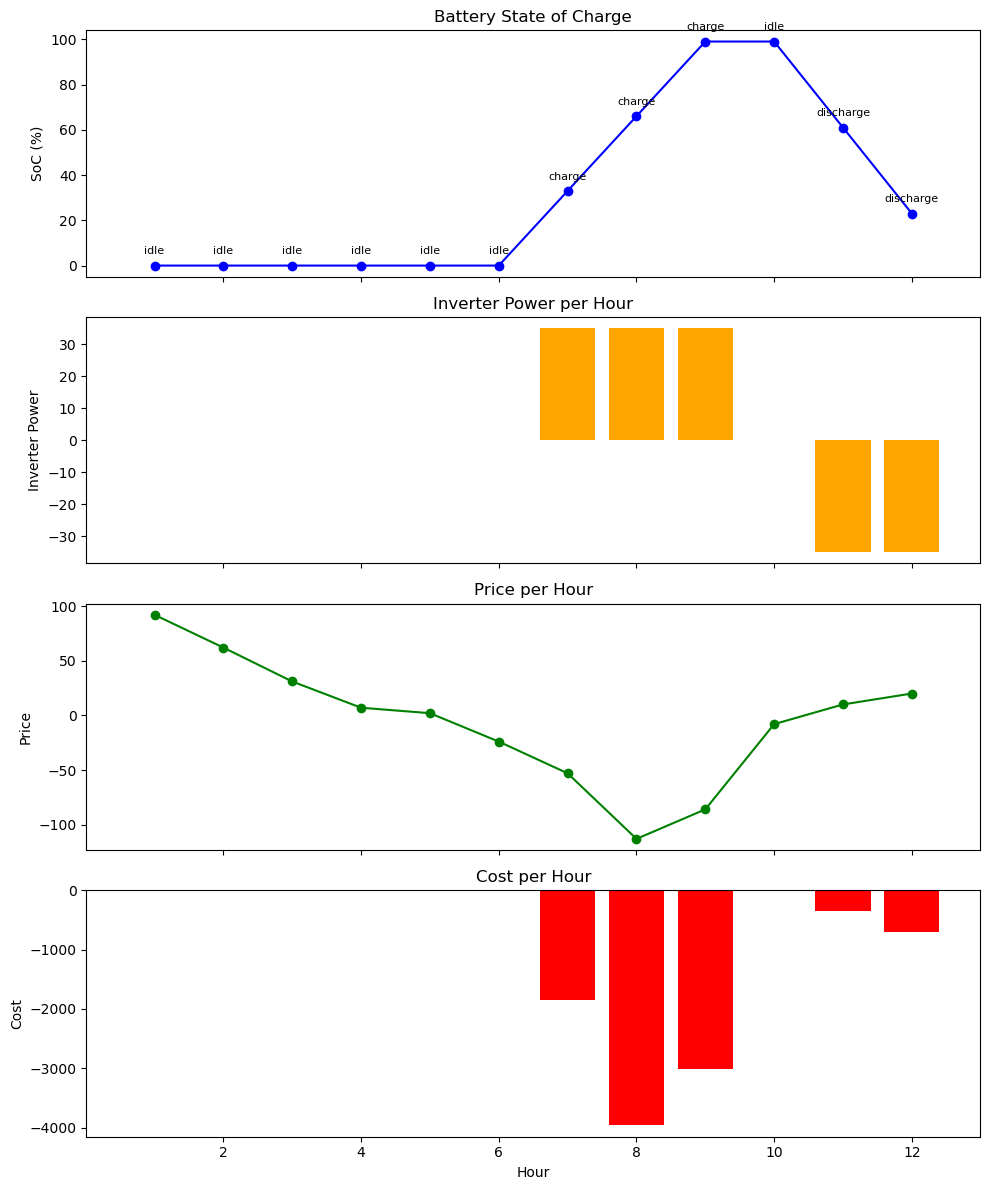

In [5]:
# --- Prepare data for plotting ---
# Collect hours from soc, skip hour 0 (initial state)
hours = sorted(results["soc"].keys())
hours = [h for h in hours if h > 0]

# Build lists, casting to int for plotting
soc = [int(results["soc"][h]) for h in hours]
inverter_power = [int(results["inverter_power"].get(h, 0)) for h in hours]
price = [int(results["price"].get(h, 0)) for h in hours]
cost = [int(results["cost"].get(h, 0)) for h in hours]
schedule = [results["schedule"].get(h, "idle") for h in hours]

# --- Plot ---
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 1. SoC line plot
axs[0].plot(hours, soc, marker='o', color='blue')
axs[0].set_ylabel("SoC (%)")
axs[0].set_title("Battery State of Charge")
for h, action in zip(hours, schedule):
    axs[0].text(h, soc[hours.index(h)] + 5, action, ha='center', fontsize=8)

# 2. Inverter power bar plot
axs[1].bar(hours, inverter_power, color='orange')
axs[1].set_ylabel("Inverter Power")
axs[1].set_title("Inverter Power per Hour")

# 3. Price line plot
axs[2].plot(hours, price, marker='o', color='green')
axs[2].set_ylabel("Price")
axs[2].set_title("Price per Hour")

# 4. Cost bar plot
axs[3].bar(hours, cost, color='red')
axs[3].set_ylabel("Cost")
axs[3].set_title("Cost per Hour")
axs[3].set_xlabel("Hour")

plt.tight_layout()
plt.show()